### Mike Ogrysko
### CS 737 Machine Learning

Image classification using PyTorch

- Intel image dataset from Kaggle - https://www.kaggle.com/puneet6060/intel-image-classification
- OpenCV image feature extraction library - https://docs.opencv.org/3.4.10/
- Identification of color channels
- PyTorch Neural Network

In [3]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import balanced_accuracy_score

In [4]:
#training and test lists of X and y
X_tr, y_tr, X_ts, y_ts = [], [], [], []
#paths for training and test sets
trainPath = "archive/seg_train/seg_train/"
testPath = "archive/seg_test/seg_test/"
#set image size
IMGSIZE = (128, 128)
#set class names
CNAMES = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
#for each label
for label in CNAMES:
    #build a path
    tr_path = trainPath + label
    #for each image in path
    for f in sorted([_ for _ in os.listdir(tr_path) if _.lower().endswith('.jpg')]):
        #resize the file given the defined image size and store in X
        X_tr += [cv2.resize(cv2.imread(os.path.join(tr_path,f)), IMGSIZE)] 
        #store the corresponding label index in y
        y_tr += [CNAMES.index(label)]
    ts_path = testPath + label
    #for each image in path
    for f in sorted([_ for _ in os.listdir(ts_path) if _.lower().endswith('.jpg')]):
        #resize the file given the defined image size and store in X
        X_ts += [cv2.resize(cv2.imread(os.path.join(ts_path,f)), IMGSIZE)] 
        #store the corresponding label index in y
        y_ts += [CNAMES.index(label)]

In [5]:
#confirm lengths of training set X and y
print("Training set X: ", len(X_tr))
print("Training set y: ", len(y_tr))


Training set X:  14034
Training set y:  14034


In [6]:
#confirm lengths of test set X and y
print("Testing set X: ", len(X_ts))
print("Testing set y: ", len(y_ts))


Testing set X:  3000
Testing set y:  3000


**Identification of color channels**

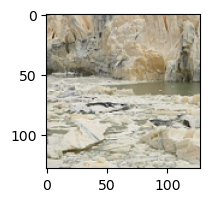

Height:  128
Width:  128
Channels:  3
Label:  glacier


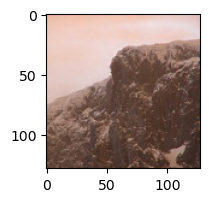

Height:  128
Width:  128
Channels:  3
Label:  mountain


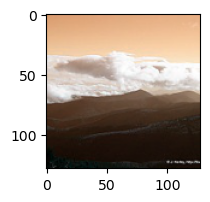

Height:  128
Width:  128
Channels:  3
Label:  mountain


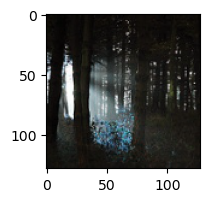

Height:  128
Width:  128
Channels:  3
Label:  forest


In [7]:
#display images
#set batch size
batch = 4
for i in range(batch):
    #get random number from trainSet
    n = random.randint(0,len(X_tr)-1)
    #set image size
    plt.figure(figsize=(2,2))
    #show image
    plt.imshow(X_tr[n])
    plt.show()
    #show dimensions and channels
    print('Height: ', X_tr[n].shape[0])
    print('Width: ', X_tr[n].shape[1])
    print('Channels: ', X_tr[n].shape[2])
    #show labels
    print('Label: ', CNAMES[y_tr[n]])


In [8]:
#Convert the imageset to numpy array, such as the array size:
#(14034, 128, 128, 3)
#Scale the imageset to [0-1].

np_trainSet_X = np.array(X_tr)
np_trainSet_y = np.array(y_tr)
np_testSet_X = np.array(X_ts)
np_testSet_y = np.array(y_ts)

In [9]:
print(np_trainSet_X.shape)
print(np_trainSet_y.shape)
print(np_testSet_X.shape)
print(np_testSet_y.shape)

(14034, 128, 128, 3)
(14034,)
(3000, 128, 128, 3)
(3000,)


In [10]:
np_trainSet_X[:,:,:,0].max()

255

In [11]:
np_trainSet_X[:,:,:,0].min()

0

In [12]:
#scale image set
np_trainSet_X = np_trainSet_X/255.0
np_testSet_X = np_testSet_X/255.0

In [13]:
#confirm std max
np_trainSet_X[:,:,:,0].max()

1.0

In [14]:
#confirm std min
np_trainSet_X[:,:,:,0].min()

0.0

In [15]:
np_trainSet_X[0].shape

(128, 128, 3)

**PyTorch Neural Network**

In [16]:
#nn
class CustomMLP(nn.Module):
    """ A PyTorch neural network model """
    def __init__(self, n_hidden=30, epochs=500, eta=0.001, minibatch_size=1000):
        super(CustomMLP, self).__init__()
        self.n_hidden = n_hidden  # hidden layer size
        self.epochs = epochs  # number of learning iterations
        self.eta = eta  # learning rate
        self.minibatch_size = minibatch_size  # size of training batch - 1 would not work
        self.fc1, self.fc2, self.fc2plus, self.fc2plus2, self.fc3 = None, None, None, None, None

    def _forward(self, X, apply_softmax=False):
        assert self.fc1 != None
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = F.relu(self.fc2plus(X))
        X = F.relu(self.fc2plus2(X))
        X = self.fc3(X)
        if apply_softmax:
            X = F.softmax(X, dim=1)
        return X

    def _reset(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                 m.reset_parameters()

    def predict(self, X):
        assert self.fc1 != None
        net_out = self._forward(X, apply_softmax=True)
        p_values, indices = net_out.max(dim=1)
        return indices

    def fit(self, X_train, y_train):
        self._reset()  # Reset the neural network weights
        n_output= np.unique(y_train).shape[0]  # number of class labels
        n_features= X_train.shape[1]

        self.fc1 = nn.Linear(n_features, self.n_hidden)  # A simple input layer
        self.fc2 = nn.Linear(self.n_hidden, self.n_hidden)  # A simple hidden layer
        self.fc2plus = nn.Linear(self.n_hidden, self.n_hidden)  # Adding another simple hidden layer
        self.fc2plus2 = nn.Linear(self.n_hidden, self.n_hidden)  # Adding another simple hidden layer
        self.fc3 = nn.Linear(self.n_hidden, n_output)  # A simple output layer
        
        #changing optimizer per recommendation
        optimizer = optim.SGD(self.parameters(), lr=self.eta, momentum=0.9)
        #optimizer = optim.Rprop(self.parameters(), lr=self.eta)
        loss_func = nn.CrossEntropyLoss()

        for _ in range(self.epochs):
            indices = np.arange(X_train.shape[0])
            
            for start_idx in range(0, indices.shape[0] - self.minibatch_size + 1, self.minibatch_size):
                batch_idx = indices[start_idx:start_idx + self.minibatch_size]
                optimizer.zero_grad()
                
                net_out = self._forward(X_train[batch_idx])
                
                loss = loss_func(net_out, y_train[batch_idx])
                loss.backward()
                optimizer.step()
                

In [17]:
# Convert to tensors
X_train, y_train = torch.FloatTensor(np_trainSet_X), torch.LongTensor(np_trainSet_y)
X_test, y_test = torch.FloatTensor(np_testSet_X), torch.LongTensor(np_testSet_y)


In [18]:
#flatten image
X_train = torch.flatten(X_train, start_dim=1)
X_test = torch.flatten(X_test, start_dim=1)

In [19]:
#classifier
clf = CustomMLP()


In [20]:
#fit
clf.fit(X_train, y_train)


In [21]:
#predict
y_pred = clf.predict(X_test)


In [22]:
#check classes in prediction
print(y_pred.unique())

tensor([0, 1, 2, 3, 4, 5])


In [23]:
#accuracy
balanced_accuracy_score(y_test,y_pred)


0.5551349048932958